In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.close('all')

In [82]:
# load in Jones data (this is my training/test data)
df = pd.read_pickle('output/features_svm')

# load in Gruendl data (I will use this later on the fully trained model, to see how well it works on distinguishing contaminants)
df2 = pd.read_pickle('output/features_svm_gruendl_testdata')

In [83]:
# for simplicity, we shall consider the binary classification 'YSO' versus 'non-YSO'.
# I label all subgroups 'YSO1', 'YSO2', 'YSO3', 'YSO4', 'HII', and 'HII/YSO3' sources as 'YSO'
# all other objects (background galaxies, AGB stars, PNe, etc.) will fall in the 'non-YSO' class.
df['class'] = 'non-YSO'
df['class'][df['SpClass'] == 'YSO1'] = 'YSO'
df['class'][df['SpClass'] == 'YSO2'] = 'YSO'
df['class'][df['SpClass'] == 'YSO3'] = 'YSO'
df['class'][df['SpClass'] == 'YSO4'] = 'YSO'
df['class'][df['SpClass'] == 'HII'] = 'YSO'
df['class'][df['SpClass'] == 'HII/YSO3'] = 'YSO'

In [84]:
# create  data
X = df[['[8.0]','[4.5-8.0]','[8.0-24]','sigmadust']]
y = df['class']

In [85]:
# I will use the Gruendl's data to test the trained model in the end. This list is separated in YSO and non-YSO list (background galaxies, AGB stars, PNe). The YSO list has shown to be ~99% accurate (Jones et al. 2017).
X2_test = df2[['[8.0]','[4.5-8.0]','[8.0-24]','sigmadust']]
y2_test = df2['class']

In [86]:
####################################
# TRAINING THE SVM
####################################

# import SVM modules
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sys import exit

In [87]:
# initiate model
svc = SVC(kernel='linear')
model = make_pipeline(svc)

In [88]:
# Split the dataset in 70%/30% parts (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

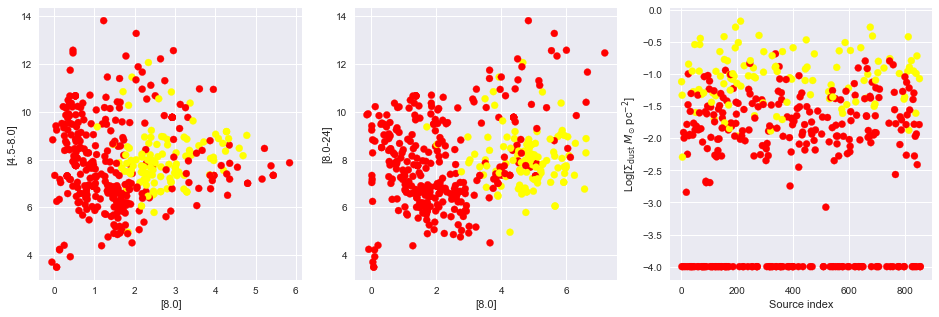

In [89]:
# Visualize the data
# first make color series to distinguish classes
import vis_data

col = np.copy(y_train)
col[y_train == 'non-YSO'] = 'red'
col[y_train == 'YSO'] = 'yellow'
fig = vis_data.visdata(X_train.index,X_train['[8.0]'],X_train['[4.5-8.0]'],X_train['[8.0-24]'],X_train['sigmadust'],col,'train_test')
plt.show()

In [90]:
# get optimal parameters using a grid search cross-validation
# for now, use linear kernel which seems to work good. Degree and gamma are defined but now used in this kernel.
C_range = np.logspace(-2, 0, 10)
degree= [1]
gamma = [0]
grid_pars = {'svc__C': C_range,'svc__degree':degree,'svc__gamma':gamma}

In [91]:
# do a 10 Kfold with stratification to ensure a balanced training/test set
# make sure optimal parameters do not fall on edge of the grid
cv = StratifiedKFold(n_splits=10)
grid = GridSearchCV(model, grid_pars, cv=cv)
grid.fit(X_train, y_train)

print grid.best_params_

{'svc__gamma': 0, 'svc__degree': 1, 'svc__C': 0.12915496650148839}


In [92]:
# save the grid of searched hyperparameters, and the mean + std of the K-fold cross validations to plot later
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
results = pd.DataFrame({"hparam": C_range,"mean": means,"std":stds})

In [93]:
# test the model with the test data the model hasn't seen
# print classification report -> LOOKS GREAT (~94% accuracy)
model = grid.best_estimator_
y_test_fit = model.predict(X_test)

print '=============Classification report using 50/50============='
print classification_report(y_test, y_test_fit)

=============Classification report using 50/50=============
             precision    recall  f1-score   support

        YSO       0.88      0.90      0.89        50
    non-YSO       0.96      0.95      0.96       132

avg / total       0.94      0.94      0.94       182



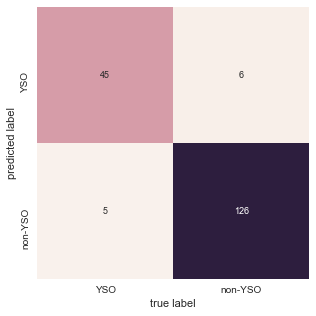

In [94]:
# plot confusion matrix to get a better sense of what has been classified.
conf_mat = confusion_matrix(y_test,y_test_fit)

fig = plt.figure(figsize=(5,5))
font = {'size':9}
plt.rc('font', **font)

sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['YSO','non-YSO'],
            yticklabels=['YSO','non-YSO'])

plt.xlabel('true label')
plt.ylabel('predicted label');
plt.savefig('output/confusion_matrix.pdf', dpi=150, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [95]:
# now there is no reason to hold back part of the training data. train the model with ALL data
y_fit = model.predict(X)

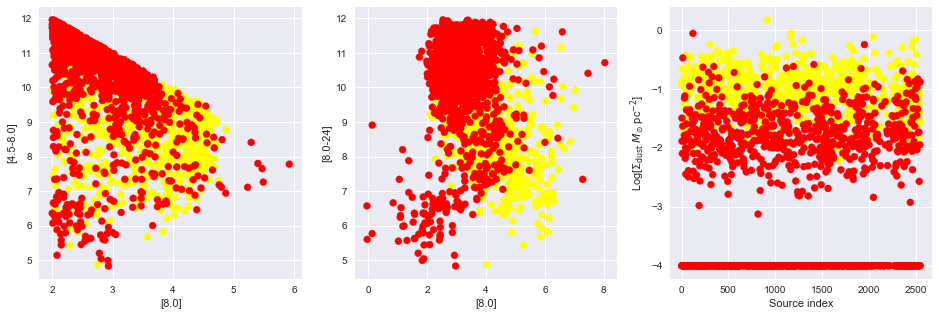

In [96]:
# now for a serious another test; the Gruendl data...which is complex, as it ONLY contains sources within the YSO color space, but contains all contaminants. 
# visualize it:
col2 = np.copy(y2_test)
col2[y2_test == 'non-YSO'] = 'red'
col2[y2_test == 'YSO'] = 'yellow'
fig = vis_data.visdata(y2_test.index,X2_test['[8.0]'],X2_test['[4.5-8.0]'],X2_test['[8.0-24]'],X2_test['sigmadust'],col2,'gruendl')
plt.show()

In [97]:
# How well does the model separate out the YSOs in the confused color space? We expect it to be lower than the training/test score.
y2_fit = model.predict(X2_test)

print '======Classification report on unseen, complex data========'
print classification_report(y2_test, y2_fit)
print '==========================================================='

======Classification report on unseen, complex data========
             precision    recall  f1-score   support

        YSO       0.90      0.65      0.75       705
    non-YSO       0.83      0.96      0.89      1270

avg / total       0.85      0.85      0.84      1975



In [98]:
# The model has a 0.85 precision and recall on data that is overlapping in color-color and color-magnitude space!
# This means the additional feature (the dust surface density) is very powerful in separating the classes